# CNN Cancer Detection 

In [4]:
# This is a CNN Cancer Detection case using the kaggle Histopathologic Cancer Detection competition data

* ****Import Library****

In [5]:

import pathlib
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw


# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.ops.array_ops import tensor_scatter_update
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Activation, Add, GlobalAveragePooling2D 
from tensorflow.keras import regularizers

In [6]:
# # Detect TPU, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

* ****Load Data****

In [7]:
# get training data
train_img_location = "/kaggle/input/histopathologic-cancer-detection/train"
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(len(labels))
labels.head()

220025


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [8]:
#get test files
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

* ****exploratory data analysis (EDA)****  

Visualize and Clean the Data

In [9]:
train_data.head()
train_data.describe()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
# Label Count Info:

print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
 

   Label Counts
0        130908
1         89117


Cancer Images:


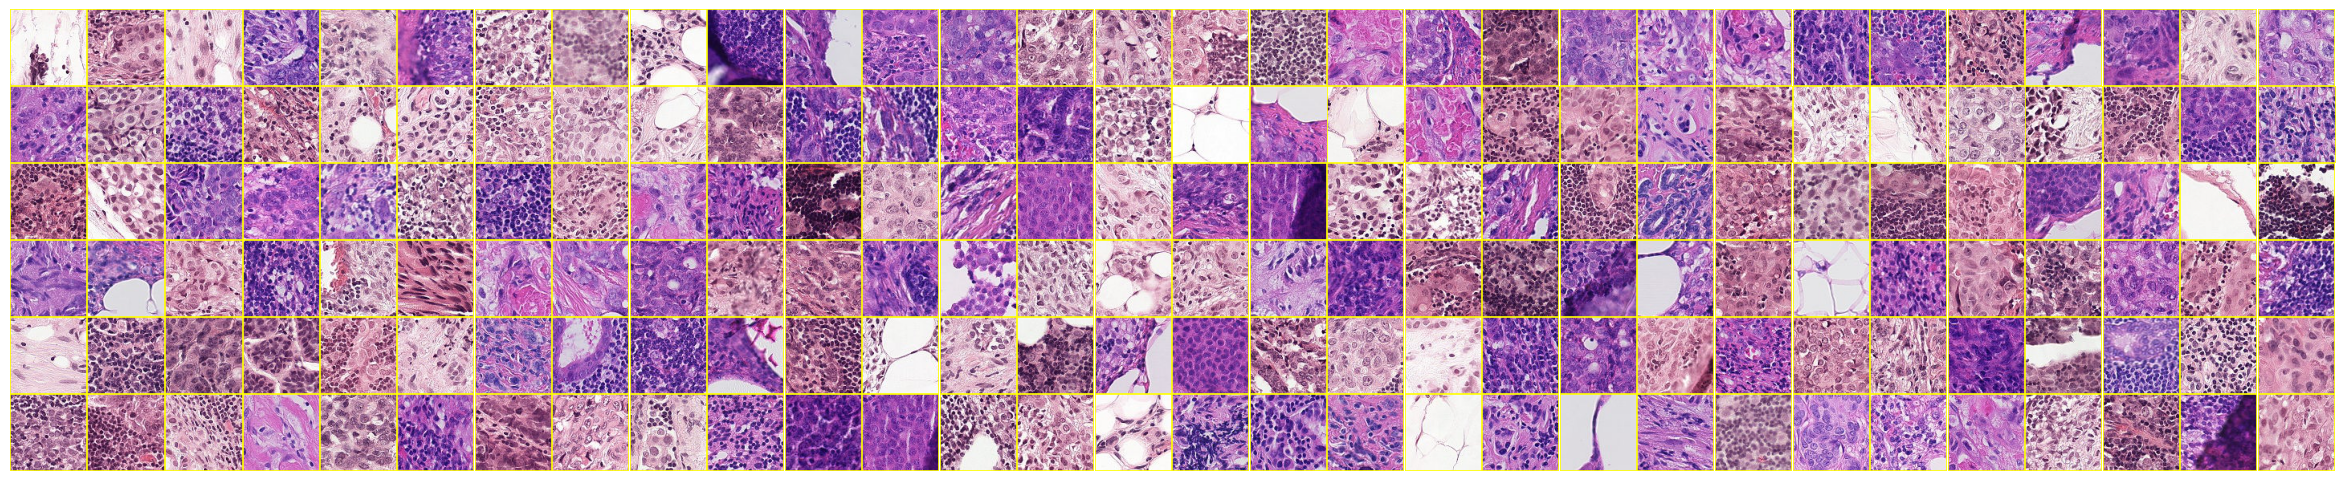

In [11]:
cancer = labels.loc[labels['label']==1]['id'].to_numpy()    # get the ids of cancer cases
normal = labels.loc[labels['label']==0]['id'].to_numpy()       # get the ids of the normal cases

# Create a subplot to display train examples
nrows,ncols=6,30
fig,ax = plt.subplots(nrows,ncols,figsize=(30,6))
plt.subplots_adjust(wspace=0, hspace=0) 
print("Cancer Images:")
# Get the last nrows*ncols images and display
for i,j in enumerate(cancer[:nrows*ncols]):
    fname = os.path.join(train_img_location ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='yellow')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

Normal Images:


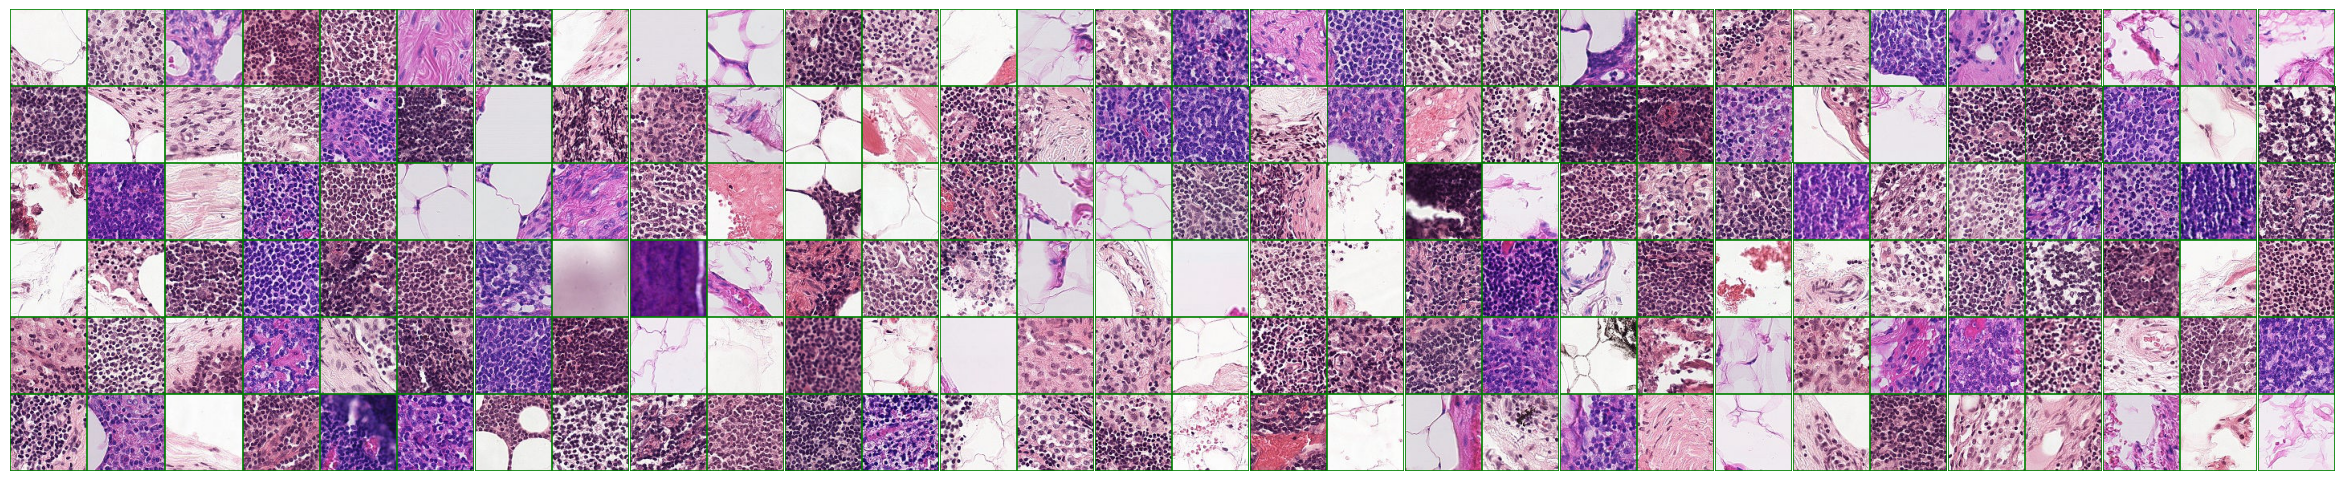

In [12]:
nrows,ncols=6,30
fig,ax = plt.subplots(nrows,ncols,figsize=(30,6))
plt.subplots_adjust(wspace=0, hspace=0) 
print("Normal Images:")
for i,j in enumerate(normal[:nrows*ncols]):
    fname = os.path.join(train_img_location ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='green')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')

* ****Model Architecture****  

In [13]:
BATCH_SIZE = 256
RANDOM_STATE = 49
from sklearn.utils import shuffle
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)


# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)
print(train_data["id"])

92002     9b1f3082f427b7f76e711295de2806060a223dd9.tif
137370    8e871edc0d02ebc470dbdcffa502ac52e0c6d29e.tif
119572    b2c9725c73d290b0e7aa22f89369e3f757581483.tif
16082     da09fb7690e0b509db6d595cd101f9146895069a.tif
217979    da1bfd1ef81aea0a1cc574039c7a7d3eeb1fc8c6.tif
                              ...                     
7924      2babaf014b54c65ccc650c6e43ec4c759603eb48.tif
19638     1dbac37e0b3ac5caa6793c3675f7f8cba0873a99.tif
81397     d16c5a5cb31dd6168ba48985246aba99e201fea9.tif
186029    710837c5cac9f89c99eab24c7cddd2835206195f.tif
426       496627cf8196e992dd5e76231dd7db6f6d71fcbd.tif
Name: id, Length: 220025, dtype: object


In [14]:
# Data augmentation applied to the training dataset using ImageDataGenerator to create additional training data and prevent overfitting.
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.


In [15]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64)) 

Found 33003 validated image filenames belonging to 2 classes.


In [16]:
model = Sequential()

# Conv2D layers with 32, 64, 128, and 256 filters respectively, with a kernel size of (3,3) and ReLU activation function. The input shape is (64,64,3) as the images are RGB with dimensions 64x64.

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# MaxPooling2D layers with a pool size of (2,2) after each Conv2D layer to reduce the spatial dimensions of the feature maps.
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Dropout layer with a rate of 0.5 after the first fully connected layer to reduce overfitting.
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# Adam optimizer, binary cross-entropy loss function, and accuracy metric used for model compilation.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up the data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               shear_range=0.2,
                                                               zoom_range=0.2,
                                                               horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [17]:
# check if use GPU, should be cudas 0, otherwise print 'CPU'
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
print(torch.cuda.is_available())

cuda:0
True


In [18]:
# Train the model
# Train the model for 12 epochs with a batch size of 32 and use the validation set for monitoring the model's performance during training.
history = model.fit(train_generator,
                    epochs=12,
                    batch_size=32,
                    validation_data=valid_generator,
                     verbose=1)

Epoch 1/12
731/731 [==============================] - 1114s 2s/step - loss: 0.4484 - accuracy: 0.7958 - val_loss: 0.4080 - val_accuracy: 0.8126
Epoch 2/12
731/731 [==============================] - 384s 525ms/step - loss: 0.3781 - accuracy: 0.8345 - val_loss: 0.3551 - val_accuracy: 0.8442
Epoch 3/12
731/731 [==============================] - 294s 402ms/step - loss: 0.3338 - accuracy: 0.8570 - val_loss: 0.3276 - val_accuracy: 0.8566
Epoch 4/12
731/731 [==============================] - 286s 391ms/step - loss: 0.3016 - accuracy: 0.8731 - val_loss: 0.2985 - val_accuracy: 0.8735
Epoch 5/12
731/731 [==============================] - 288s 394ms/step - loss: 0.2793 - accuracy: 0.8850 - val_loss: 0.2666 - val_accuracy: 0.8879
Epoch 6/12
731/731 [==============================] - 287s 392ms/step - loss: 0.2584 - accuracy: 0.8939 - val_loss: 0.2465 - val_accuracy: 0.8988
Epoch 7/12
731/731 [==============================] - 286s 391ms/step - loss: 0.2402 - accuracy: 0.9021 - val_loss: 0.2540 - v

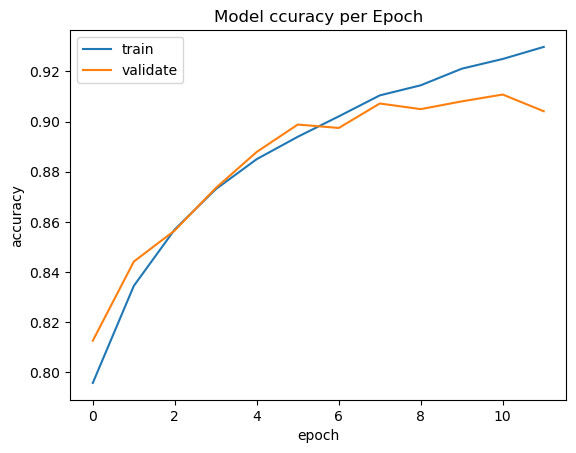

In [19]:
# plot model accuracy per epoch 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model ccuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

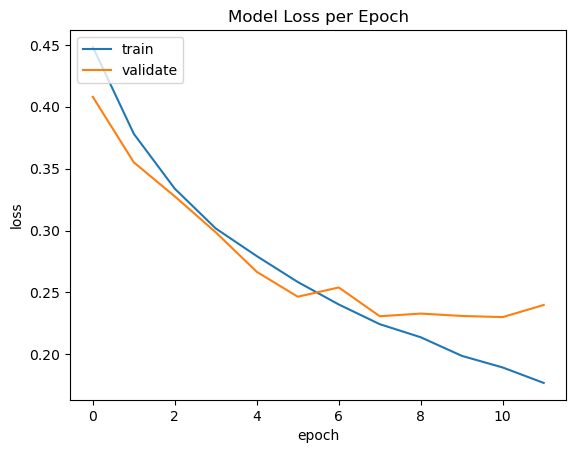

In [20]:
# plot model loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

* ****Conculsion****   

From the above accuracy and loss draw, we can figure out that the model works well and have a high accuracy.
I used the dropout to void overfitting, but after the epoch >10, the validate accuracy are still going down, so I think the best epoch setting is 10 to 12.

* ****Predict Test Data****   

In [21]:
test_data = pd.DataFrame({'id':os.listdir(test_path)})

In [22]:
# test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

 

Found 57458 validated image filenames.


In [23]:
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 316s 5ms/step


In [24]:
#create submission
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0

0    36577
1    20881
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7f912479b350>,
 [Text(-0.45765767501957344, 1.0002746885209475, '0-Non-cancerous'),
  Text(0.4576576750195731, -1.0002746885209477, '1-Cancerous')],
 [Text(-0.2496314591015855, 0.5456043755568803, '63.66%'),
  Text(0.2496314591015853, -0.5456043755568806, '36.34%')])

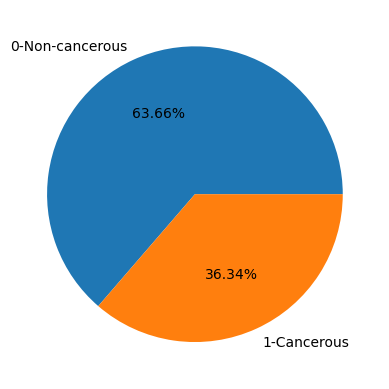

In [25]:
#Submission label pie chart
unique_counts = submission_df['label'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-cancerous','1-Cancerous'],
        autopct='%1.2f%%'
       )

In [26]:
#Competition Submission
submission_df.to_csv('submission.csv', index=False)